# Validator Returns with Post-merge MEV

As Ethereum approaches the point at which the beacon chain — launched in December 2020 — will become the consensus engine for mainnet, much online coverage has focused on the end of Proof of Work mining and concomitant reductions in both energy usage and issuance of Ether (never mind that Proof of Stake is [more secure a resistant to centralisation](https://vitalik.ca/general/2020/11/06/pos2020.html)). However another consequence of the beacon chain taking over transaction inclusion and ordering duties is that the fees currently paid to miners for transaction inclusion will instead be paid to the block *proposer*. That is, a validator, selected at random to propose a block every 12 seconds.

The manner in which validators are selected to propose blocks does not change from the existing process, and as I showed in my [first article on validator returns](https://pintail.xyz/posts/beacon-chain-validator-rewards/#block-rewards), this produces some random variation in revenue, even when validators participate perfectly. So for this article, the question is how much validator returns are affected by the fees they receive for including transactions on Ethereum's execution layer.

## But What's MEV?

In the title, I've referred to these execution layer fees as 'MEV'. Perhaps this is a little confusing — [the term MEV](https://docs.flashbots.net/Flashbots-auction/miners/faq/#what-is-mev) can stand for "miner extractable value" or "maximal extractable value" — neither of which seems to describe the fees received by validators for including/ordering transactions in post-merge Ethereum blocks. Validators are not miners, and in what sense might this value be 'maximal', anyway? The reality is that the term MEV has entered common usage to describe whatever value is — or could be — paid to the the entity responsible for transaction inclusion and ordering. To reduce the ambiguity, the Flashbots team have introduced the term "Realised Extractable Value" to descibe the value actually obtained, rather than a theoretical maximum. However, since 'MEV' is the term with widespread adoption, it is what I will use here (I know [all too well](https://pintail.medium.com/uniswap-a-good-deal-for-liquidity-providers-104c0b6816f2) how difficult it can be to change a term once it has entered widespread use).

So why use a fancy term (MEV) when we could use a straightforward one (transaction fees)? The answer is that the revenue from transaction inclusion and ordering has been revolutionised since Flashbots introduced a fork of the dominant Ethereum execution client, geth. As of August 2022, [approximately 74%](https://dashboard.flashbots.net/) of Ethereum's hashrate is running mev-geth, since doing so allows miners to receive bundles of transactions which exploit time-sensitive profit opportunities and are rewarded with direct payment (previously much of this revenue was wasted in a wasteful *priority gas auction* process). The use of the term MEV recognises this new complexity. Furthermore, the opportunity for validators to benefit from the same revenue stream post-merge is being offered by Flashbots through [mev-boost](https://boost.flashbots.net/). However, whether or not validators choose to run mev-boost, the fees they receive for block proposal can still be described in a broad sense as MEV.

## Previous Model

An article setting out [an early exploration](https://hackmd.io/@flashbots/mev-in-eth2#) (with [accompanying notebook](https://github.com/flashbots/eth2-research/blob/main/notebooks/mev-in-eth2/eth2-mev-calc.ipynb)) of the implications of this change  was published by Alex Obadia and Taarush Vemulapalli from Flashbots in July 2021, by looking specifically at Flashbots transaction bundles from a sample of approx 100,000 blocks. Firstly they averaged across blocks, applying a fixed amount of MEV per block. Then they looked at the 1st and 99th centiles within that dataset to establish some bounds for the impact on validator returns (finding a very wide varation as a result of this approach).

In this article I'll develop this approach a bit further by:
1. Using data from after the London hard fork, since the new fee market dynamics introduced by EIP-1559 are expected to have significantly altered the economics of post-Merge MEV.
1. Looking at fee revenue in its entirety (rather than only Flashbots bundles), since all miner fee revenue can be considered a form of MEV.
1. Using a larger dataset and considering how the levels of MEV have varied over time.
1. Modelling the whole distribution of outcomes.
1. Calculating how these distributions change for users running multiple validators.

## Selecting a Dataset

To try and draw some general conclusions, we'd like to select the largest dataset available for which the protocol is stable. As explained in my [last article](https://pintail.xyz/posts/gas-market-analysis/), the transaction fee market changed significantly in August 2021 due to the implimentation of EIP-1559 as part of the London hard fork which went live at block 12,965,000. The hard fork following this was [Gray Glacier](https://blog.ethereum.org/2022/06/16/gray-glacier-announcement), which went live at block 15,050,000 and pushed back Ethereum's difficulty bomb. However, average block intervals had begun to change a while before ths, changing network conditions. We'll therefore look at the data up to block 14,714,999 which was mined in May 2022. This gives us 1,750,000 blocks — approximately 9 months of data — to work with.

Having chosen this block range, we need to identify how much revenue is going to the miner of each block. For this we'll be using Flashbots' [mev-inspect-py](https://github.com/flashbots/mev-inspect-py) tool which (amongst many other features) scrapes blocks for "coinbase transfer" transactions as well as aggregating fees. This is because there are two main ways in which miners are paid for including Flashbots bundles of MEV-carrying transactions — either by setting a sufficiently high transaction fee, or including a direct payment to the miner as part of the transaction.

We have to do a little bit more work to determine the amount of MEV per block. First we have to exclude transactions that miner pay to themselves since these are not economically meaningful. This requires identifying multiple addresses controlled by a single mining pool and filtering out transactions between these addresses (following some manual sleuthing on Etherscan)

In [8]:
import math
from random import randrange, random
from datetime import datetime, timedelta
from time import time

import psycopg2
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

from web3 import Web3

start_block = 12965000
end_block = 14714999

SECONDS_PER_SLOT = 12

# close any existing connection to mev-inspect database

try:
    cursor.close()
    connection.close()
except:
    pass

# connect to mev-inpect database

connection = psycopg2.connect(
    host="127.0.0.1",
    port=5433,
    user="postgres",
    password="password",
    database="mev_inspect"
)
connection.autocommit = True
cursor = connection.cursor()

In [2]:

sql = (
    "SELECT * FROM block_totals WHERE block_number BETWEEN %s AND %s "
    "ORDER BY block_number"
)
cursor.execute(sql, (start_block, end_block))

(
    block_numbers, block_timestamps, base_fees, gas_used,
    net_transfers, net_fees, burned_fees, ts_diff_1, ts_diff_2
) = zip(*cursor.fetchall())

miner_extracted = [float(t + f) for t, f in zip(net_transfers, net_fees)]

# save data into a pandas dataframe 

df = pd.DataFrame({
    'block_number': [int(bn) for bn in block_numbers],
    'timestamp': pd.to_datetime(block_timestamps),
    'gas_used': [int(gu) for gu in gas_used],
    'base_fee': [int(bf) for bf in base_fees],
    'net_transfers': [float(nt) for nt in net_transfers],
    'net_fees': [float(nf) for nf in net_fees],
    'miner_extracted': miner_extracted,
    'burned_fees': [float(bf) for bf in burned_fees]
})

# calculate average block interval

mean_interval = (df['timestamp'].max() - df['timestamp'].min()) / (len(df) - 1)

scaling_factor = SECONDS_PER_SLOT / mean_interval.total_seconds()

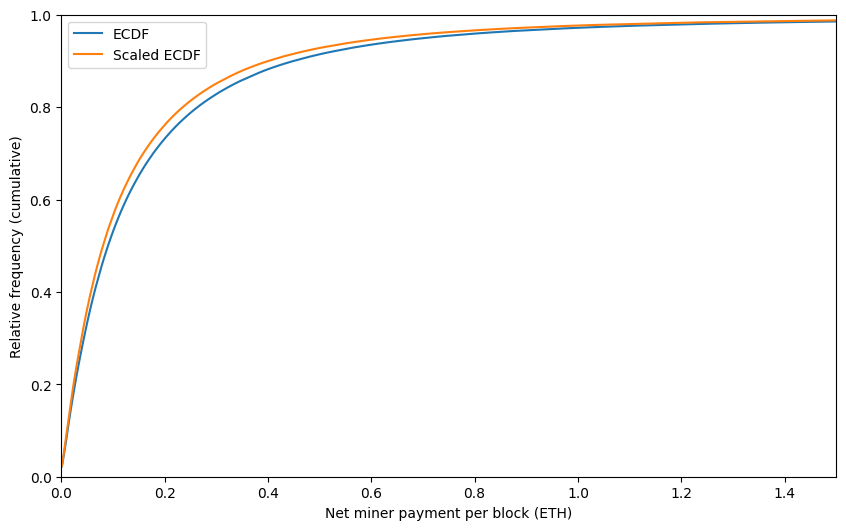

quantile,revenue,scaled
10.0%,0.012217,0.010891
25.0%,0.034802,0.031026
50.0%,0.090440,0.080627
75.0%,0.214641,0.191351
90.0%,0.449887,0.401072
99.0%,1.914676,1.706923
99.9%,14.542468,12.964526


In [4]:
vc = df['miner_extracted'].value_counts()
ecdf = vc.sort_index().cumsum()*1./len(df)

fig, ax = plt.subplots(figsize=(10, 6))
ecdf.plot(ax=ax, label='ECDF')
index = [v * scaling_factor for v in ecdf.index.values]
scaled_ecdf = ecdf.copy().set_axis(index)
scaled_ecdf.plot(ax=ax, label='Scaled ECDF')

ax.set_xlim(0,1.5)
ax.set_xlabel('Net miner payment per block (ETH)')
ax.set_ylim(0,1)
ax.set_ylabel('Relative frequency (cumulative)')
ax.legend()
plt.show()

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

table = pd.DataFrame({
    'quantile': [100 * q for q in quantiles],
    'revenue (ETH)': [ecdf[ecdf.ge(q)].index[0] for q in quantiles],
    'scaled revenue (ETH)': [
        scaled_ecdf[scaled_ecdf.ge(q)].index[0] for q in quantiles
    ]
})
table.style.hide().format({'quantile': '{:.1f}%'})

12965000 14714999 1750000
2021-08-05 12:33:42 2022-05-05 03:52:47


(0.0, 38.0)

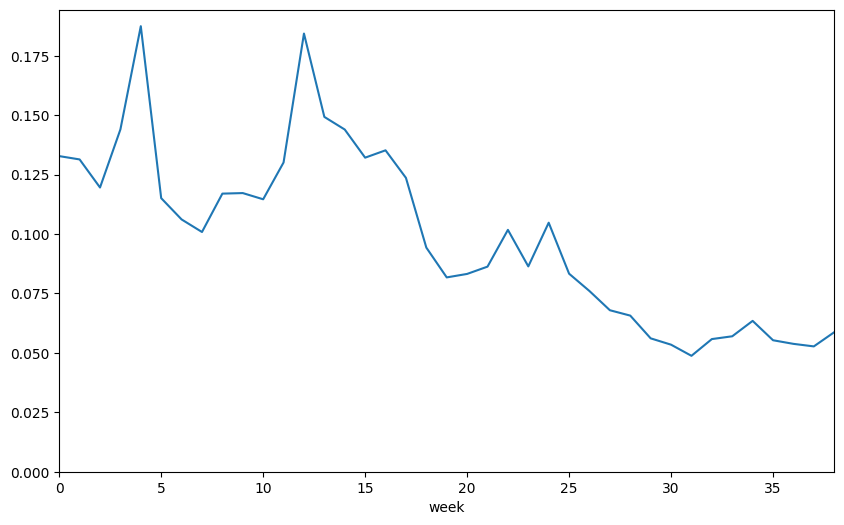

In [39]:
print(start_block, end_block, end_block - start_block + 1)
print(df.timestamp.min(), df.timestamp.max())
nanoseconds_per_week = 10**9 * 60 * 60 * 24 * 7
df['week'] = (
    df['timestamp'].astype(int) - df['timestamp'].astype(int).iloc[0]
) // nanoseconds_per_week
quantiles = {
    0.25: df.groupby(['week'])['miner_extracted'].quantile(0.25),
    0.5: df.groupby(['week'])['miner_extracted'].quantile(0.5),
    0.75: df.groupby(['week'])['miner_extracted'].quantile(0.75)
}
weekly = pd.DataFrame(quantiles)

fig, ax = plt.subplots(figsize=(10, 6))
#weekly[0.25].plot(ax=ax)
weekly[0.5].plot(ax=ax)
#weekly[0.75].plot(ax=ax)
ax.set_ylim(ymin=0)
ax.set_xlim(0, weekly.index.max())

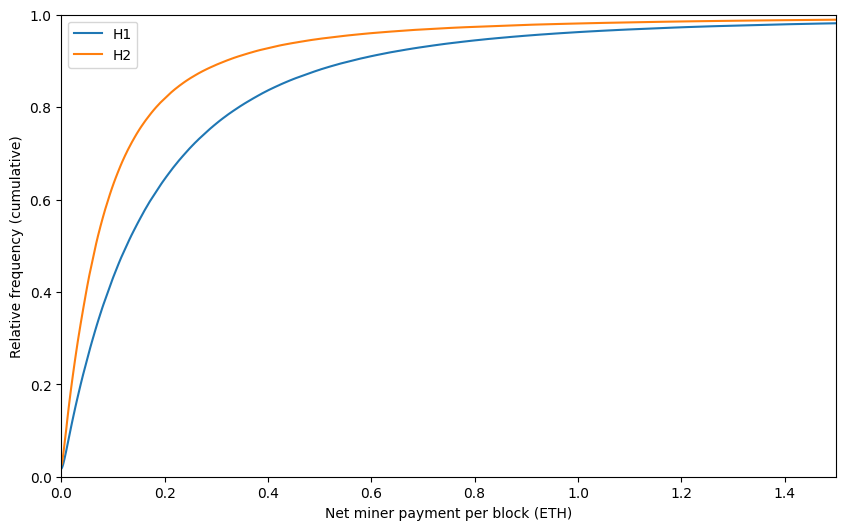

quantile,H1,H2
10.0%,0.017534,0.009303
25.0%,0.048951,0.026257
50.0%,0.126235,0.066535
75.0%,0.284773,0.150244
90.0%,0.560158,0.318315
99.0%,2.165414,1.588911
99.9%,15.030655,13.984338


In [41]:
df_h1 = df.iloc[:len(df) // 2]
vc_h1 = df_h1['miner_extracted'].value_counts()
ecdf_h1 = vc_h1.sort_index().cumsum()*1./len(df_h1)

df_h2 = df.iloc[len(df) // 2:]
vc_h2 = df_h2['miner_extracted'].value_counts()
ecdf_h2 = vc_h2.sort_index().cumsum()*1./len(df_h2)

fig, ax = plt.subplots(figsize=(10, 6))
ecdf_h1.plot(ax=ax, label='H1')
ecdf_h2.plot(ax=ax, label='H2')

ax.set_xlim(0,1.5)
ax.set_xlabel('Net miner payment per block (ETH)')
ax.set_ylim(0,1)
ax.set_ylabel('Relative frequency (cumulative)')
ax.legend()
plt.show()

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

table = pd.DataFrame({
    'quantile': [100 * q for q in quantiles],
    'H1': [ecdf_h1[ecdf_h1.ge(q)].index[0] for q in quantiles],
    'H2': [ecdf_h2[ecdf_h2.ge(q)].index[0] for q in quantiles]
})
table.style.hide().format({'quantile': '{:.1f}%'})

In [5]:
# assume 2**19 validators (524,288)
num_validators = 2**19
validators = [[] for i in range(num_validators)]
seconds_per_year = 31556952
slots_per_year = seconds_per_year // 12

start_time = time()
last_update = 0

for slot in range(slots_per_year):
    # random selection of validator as proposer
    validators[randrange(num_validators)].append(
        # random sampling of MEV level for the block
        #scaled_ecdf[scaled_ecdf.ge(random())].index[0]
        scaled_ecdf.index[np.argmax(scaled_ecdf.array >= random())] # faster
    )
    t = time()
    if t - last_update > 0.1:
        percentage = 100 * (slot+1) / slots_per_year
        elapsed = timedelta(seconds=int(t - start_time))
        print(f"{percentage:.2f}% / {elapsed} elapsed", end='\r')
        last_update = t

quantile,1,2,4,8,16,32
10.0%,0.517229,0.968965,1.379644,1.721910,2.013674,2.252019
25.0%,1.084573,1.513788,1.851899,2.129632,2.348972,2.532519
50.0%,2.059184,2.341678,2.540059,2.687845,2.809444,2.923725
75.0%,3.592218,3.555469,3.516560,3.483535,3.500008,3.570339
90.0%,5.859233,5.355320,5.005385,4.841781,4.877911,5.222789
99.0%,22.466158,23.407399,26.654089,23.402078,18.764263,15.969052
99.9%,186.702960,141.329611,127.329898,75.333941,44.731236,31.182974


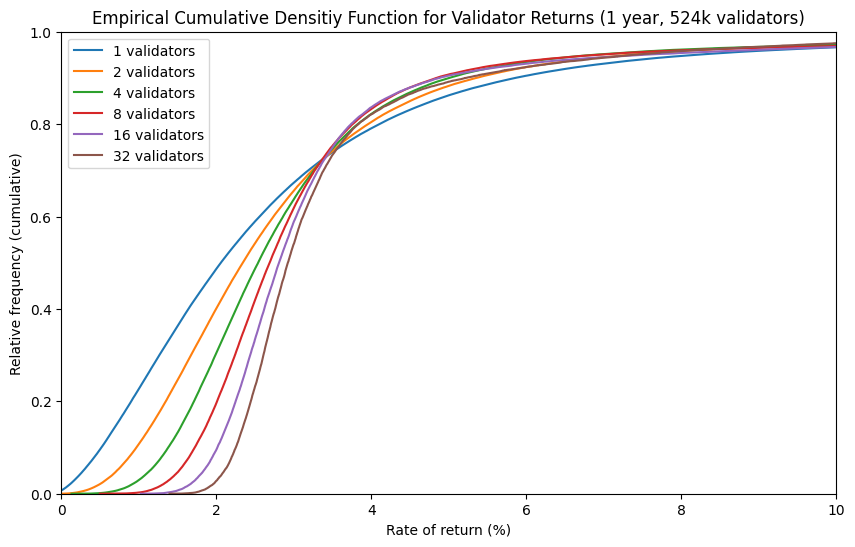

In [45]:
def sumlists(l):
    return sum([item for sublist in l for item in sublist])

rtns = []
ecdfs = []
for e in range(6):
    rtns.append(pd.Series([
        100 * sumlists(validators[i:i+2**e]) / (32 * 2**e)
        for i in range(0, num_validators, 2**e)
    ]))
    ecdfs.append(
        rtns[-1].value_counts().sort_index().cumsum() * 2**e / num_validators
    )

fig, ax = plt.subplots(figsize=(10, 6))
for e in range(6):
    ecdfs[e].plot(ax=ax, label=f'{2**e} validators')

ax.set_xlim(0,10)
ax.set_ylim(0,1)
ax.set_title(
    "Empirical Cumulative Densitiy Function for Validator Returns "
    "(1 year, 524k validators)"
)
ax.set_xlabel("Rate of return (%)")
ax.set_ylabel("Relative frequency (cumulative)")
ax.legend();
    
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

table = pd.DataFrame({'quantile': [100 * q for q in quantiles]})
for e in range(6):
    table[2**e] = [ecdfs[e][ecdfs[e].ge(q)].index[0] for q in quantiles]

table.style.hide().format({'quantile': '{:.1f}%'})

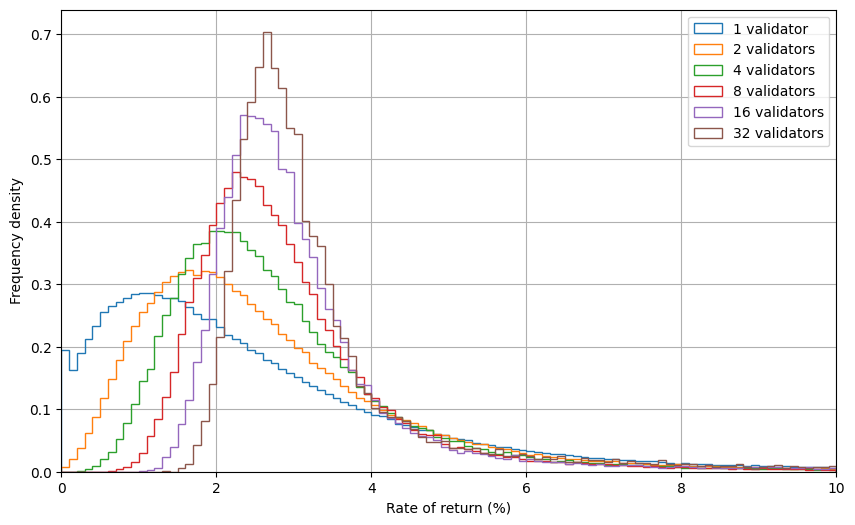

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
bins = [i / 10 for i in range(101)]
for e in range(6):
    label = f'{2**e} validators' if e > 0 else '1 validator'
    rtns[e].hist(ax=ax, density=True, bins=bins, label=label, histtype='step')
ax.set_xlim(0,10)
ax.set_ylim(ymin=0)
ax.set_xlabel("Rate of return (%)")
ax.set_ylabel("Frequency density")
ax.legend();

# To Do
* Address fixed block times
* Look into what proportion of MEV is actually being paid to the miner
* Mention that multi-block MEV becomes possible post-Merge
* Layer MEV revenue on top of the Altair modelling